# Figure 2: Adhesome genes/loci are close in HiC

In [2]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/analysis2_adhesome_HiC/correlation_clustering.py'>

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [4]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

### Load gene data

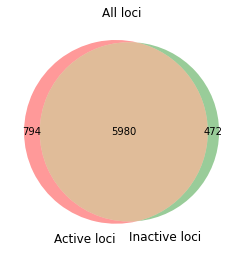

In [5]:
# Active/inactive loci (from clustering)
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)

# Active/inactive genes (from clustering)
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)

# Define active/inactive loci as the loci of active/inactive genes
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))
plt.figure()
venn2(subsets = (set(all_active_loci), set(all_active_loci_from_clustering)), 
      set_labels = ('Active loci', 'Inactive loci'))
plt.title('All loci')
plt.show()

# Redefine all active loci as the intersection between active loci determined directly by clustering'
# and all loci of active genes
all_active_loci = np.unique(list(set(all_active_loci).intersection(set(all_active_loci_from_clustering))))
all_inactive_loci = np.array(list(set(all_inactive_loci)-set(all_active_loci)))

In [6]:
# Adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)

# Define active adhesome loci as the loci of active adhesome genes (remove from the active set any gene in the
# intersection)
all_adhesome_loci = adhesome_chr_loci['locus_id'].unique()
active_adhesome_loci = adhesome_chr_loci[
    adhesome_chr_loci['gene'].isin(active_adhesome_genes)]['locus_id'].unique()
inactive_adhesome_loci = adhesome_chr_loci[
    adhesome_chr_loci['gene'].isin(inactive_adhesome_genes)]['locus_id'].unique()
intersection = set(active_adhesome_loci).intersection(set(inactive_adhesome_loci))
active_adhesome_loci = np.array(list(set(active_adhesome_loci)-set(inactive_adhesome_loci)))
# Redefine activity column of locus
adhesome_chr_loci['active'] = adhesome_chr_loci['locus_id'].isin(active_adhesome_loci)

### Active/inactive adhesome genes per chromosome

Number of active adhesome genes = 202
Number of inactive adhesome genes = 20


<Figure size 432x288 with 0 Axes>

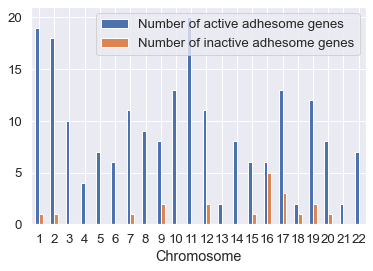

In [7]:
# Basic statistics
print('Number of active adhesome genes = '+str(len(active_adhesome_genes)))
print('Number of inactive adhesome genes = '+str(len(inactive_adhesome_genes)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci.drop_duplicates('gene')
df_bar['active adhesome gene'] = df_bar['gene'].isin(active_genes)
df_bar = df_bar.groupby(['chrom_int'])
df_bar1 = df_bar['active adhesome gene'].value_counts().unstack()
df_bar1.columns = ['Number of inactive adhesome genes', 'Number of active adhesome genes']
df_bar1 = df_bar1[['Number of active adhesome genes', 'Number of inactive adhesome genes']]

sns.set(font_scale=1.2)
plt.figure()
df_bar1.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('Chromosome')
# plt.ylabel('Number of adhesome genes')
plt.savefig(saving_main_dir+f'fig_1c.pdf', format='pdf')
plt.show()

### Select non-blacklisted adhesome loci

In [8]:
# Import list of all blacklisted loci
with open(dir_processed_hic+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

In [9]:
# Select non-blacklisted adhesome loci
selected_active_adhesome_loci = np.array(list(set(active_adhesome_loci)-set(blacklist_list)))
len(selected_active_adhesome_loci)

268

### Compare to random loci

In [10]:
# Create a dictionary of all non-blacklisted non-adhesome active for each chromosome
all_active_loci_without_adhesome = list(set(all_active_loci)
                                        -set(active_adhesome_loci)
                                        -set(blacklist_list))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome 
                            if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}
# Create a dictionary of all non-blacklisted non-adhesome inactive for each chromosome
all_inactive_loci_without_adhesome = list(set(all_inactive_loci)
                                          -set(inactive_adhesome_loci)
                                          -set(blacklist_list))
inactive_loci_pool = {chrom: [locus for locus in all_inactive_loci_without_adhesome 
                              if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [11]:
# Number of adhesome loci per chromosome
number_active_adhesome_per_chrom = {chrom: len([locus for locus in selected_active_adhesome_loci 
                                                if (int(locus.split('_')[1])==chrom)])
                                    for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci 
                                                  if (int(locus.split('_')[1])==chrom)])
                                      for chrom in np.arange(1,22+1,1)}

In [12]:
# Create list out of all adhesome and random groups of loci
with open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb') as f:
    random_active_non_adhesome_loci = np.array(pickle.load(f))
with open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'rb') as f:
    random_inactive_non_adhesome_loci = np.array(pickle.load(f))

# Group all loci list by chromosome
selected_active_adhesome_loci = selected_active_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                        for locus in selected_active_adhesome_loci])]
inactive_adhesome_loci = inactive_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                            for locus in inactive_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                                              for locus in random_active_non_adhesome_loci])]
random_inactive_non_adhesome_loci = random_inactive_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                                                  for locus in random_inactive_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([selected_active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))
loci_list_active = list(itertools.chain.from_iterable([selected_active_adhesome_loci,
                                                       random_active_non_adhesome_loci]))

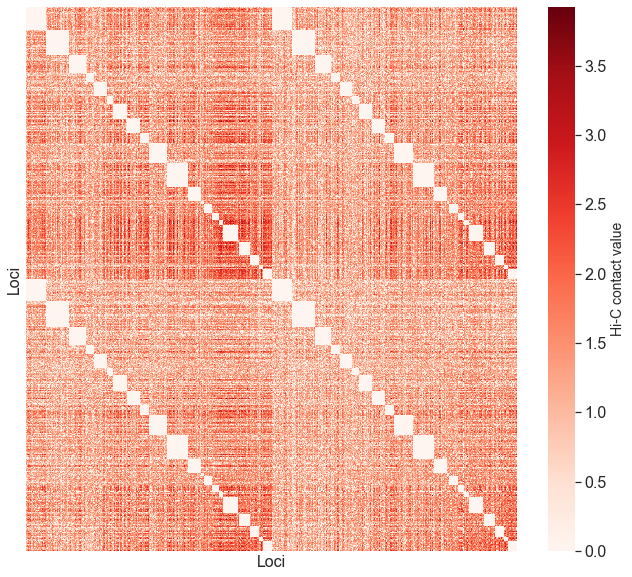

In [13]:
# Load contacts_df1
with open(saving_dir+'contacts_df1.pkl', 'rb') as f:
    contacts_df1 = pickle.load(f)

# Plot data frame as heatmap
MM = contacts_df1.loc[loci_list_active,loci_list_active].max().max()
sns.set(font_scale=1.4)
plt.figure(figsize=(11,10))
ax = sns.heatmap(contacts_df1.loc[loci_list_active,loci_list_active], cmap='Reds', 
                 xticklabels=False, yticklabels=False,
                 vmin=0, vmax=MM, 
                 cbar_kws={'label': 'Hi-C contact value'})
ax.figure.axes[-1].yaxis.label.set_size(14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xlabel('Loci', fontsize=16)
plt.ylabel('Loci', fontsize=16)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

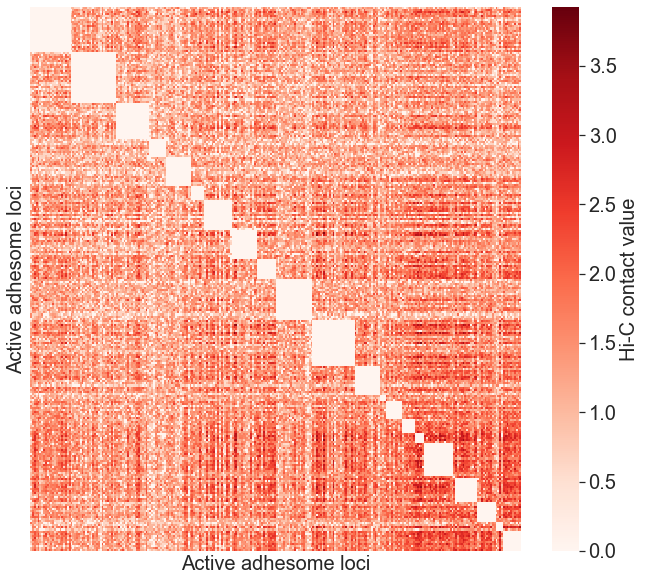

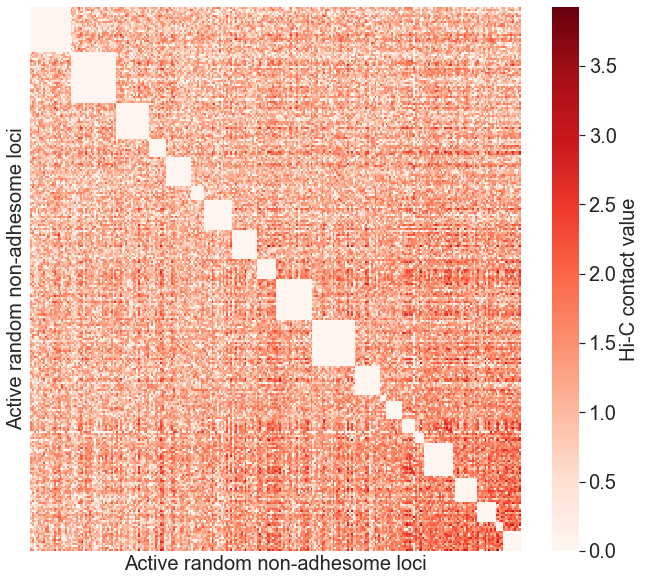

In [14]:
# Plot heatmaps

sns.set(font_scale=1.4)
plt.figure(figsize=(11,10))
ax = sns.heatmap(contacts_df1.loc[selected_active_adhesome_loci,selected_active_adhesome_loci], cmap='Reds', 
                 xticklabels=False, yticklabels=False,
                 vmin=0, vmax=MM, 
                 cbar_kws={'label': 'Hi-C contact value'})
ax.figure.axes[-1].yaxis.label.set_size(20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.xlabel('Active adhesome loci', fontsize=20)
plt.ylabel('Active adhesome loci', fontsize=20)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

sns.set(font_scale=1.4)
plt.figure(figsize=(11,10))
ax = sns.heatmap(contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci], cmap='Reds', 
                 xticklabels=False, yticklabels=False,
                 vmin=0, vmax=MM, 
                 cbar_kws={'label': 'Hi-C contact value'})
ax.figure.axes[-1].yaxis.label.set_size(20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.xlabel('Active random non-adhesome loci', fontsize=20)
plt.ylabel('Active random non-adhesome loci', fontsize=20)
# plt.savefig(saving_main_dir+f'fig_X.pdf', fomat='pdf')
plt.show()

In [15]:
# Load nonadh_contacts_ls
with open(saving_dir+'nonadh_contacts_ls.pkl', 'rb') as f:
    nonadh_contacts_ls = pickle.load(f)

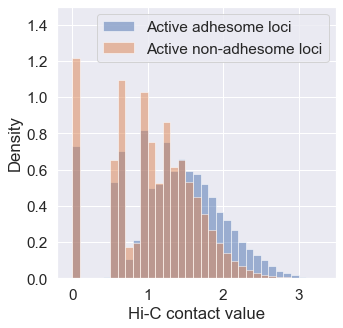

In [16]:
# Histogram of average Hi-C contacts in three active cases

# Group of active adhesome loci with itself (remove 0 values)
# active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].sum(axis=1).values
# active_adhesome_hic_with_itself = active_adhesome_hic_with_itself/(len(active_adhesome_loci)-np.array([number_active_adhesome_per_chrom[int(l.split('_')[1])] 
#                                                                                                        for l in active_adhesome_loci]))
indices = np.triu_indices(len(contacts_df1.loc[selected_active_adhesome_loci,selected_active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[selected_active_adhesome_loci,
                                                selected_active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of all active non-adhesome loci with itself
all_active_nonadhesome_hic_with_itself = nonadh_contacts_ls

# Histogram
sns.set(font_scale=1.4)
plt.figure(figsize=(5,5))
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,3.5,0.1), alpha=0.5, density=True, label='Active adhesome loci')
plt.hist(all_active_nonadhesome_hic_with_itself, 
         bins=np.arange(0,3.5,0.1), alpha=0.5, density=True, label='Active non-adhesome loci')
plt.xlabel('Hi-C contact value')
plt.ylabel('Density')
#plt.title('Interchromosomal Hi-C contact distribution')
plt.xlim(-0.2,3.5)
plt.ylim(0,1.5)
plt.legend(loc='upper right') #, bbox_to_anchor=(1,0.5)
plt.savefig(saving_main_dir+f'fig_1d3_{norm}.pdf', format='pdf')
plt.show()
# Tests

# print('Wilcoxon Rank-Sums test (blue vs orange):')
# print(ss.ranksums(active_adhesome_hic_with_itself,
#                   all_active_nonadhesome_hic_with_itself))

In [17]:
max(all_active_nonadhesome_hic_with_itself)

7.302855388941199

### Subplot of Hi-C zoomed in on only a few genes that shows the highest proximity

In [18]:
# Create a newtork 
adhesome_hic_adjacency = contacts_df1.loc[selected_active_adhesome_loci,selected_active_adhesome_loci].copy()
adhesome_hic_network = nx.from_pandas_adjacency(adhesome_hic_adjacency)
w = nx.get_edge_attributes(adhesome_hic_network, 'weight')
nx.set_edge_attributes(adhesome_hic_network, w, 'Hi-C contact')
print(nx.info(adhesome_hic_network))

Name: 
Type: Graph
Number of nodes: 268
Number of edges: 31343
Average degree: 233.9030


In [19]:
# Add node attributes
nx.set_node_attributes(
    adhesome_hic_network,
    {n: n.split('_')[1] for n in adhesome_hic_network.nodes},
    'Chromosome'
)
nx.set_node_attributes(
    adhesome_hic_network,
    {
        n: '_'.join(adhesome_chr_loci[adhesome_chr_loci['locus_id']==n]['gene'].values) 
        for n in adhesome_hic_network.nodes
    },
    'active_adhesome_genes'
)

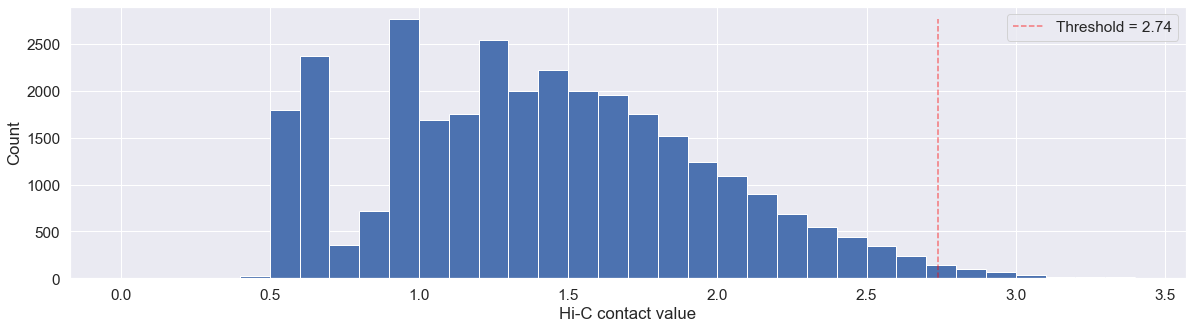

In [21]:
# Threshold the distribution of contact values
edge_hic_data = [adhesome_hic_network.get_edge_data(u, v)['Hi-C contact'] for u, v in adhesome_hic_network.edges()]
t = np.round(np.quantile(edge_hic_data, 0.99), 2)
plt.figure(figsize=(20, 5))
h = plt.hist(
    x=edge_hic_data,
    bins=np.arange(0,3.5,0.1)
)
plt.vlines(
    x=t,
    ymin=0,
    ymax=max(h[0]),
    color='red',
    linestyle='dashed',
    alpha=0.5,
    label=f'Threshold = {t}'
)
plt.xlabel('Hi-C contact value')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [92]:
# Drop edges below threshold
edges2remove = [
    e for e in adhesome_hic_network.edges() if (adhesome_hic_network.get_edge_data(e[0], e[1])['Hi-C contact']<t)
]
sub_adhesome_hic_network = adhesome_hic_network.copy()
sub_adhesome_hic_network.remove_edges_from(edges2remove)
nodes_with_neighbors = [node for node, degree in sub_adhesome_hic_network.degree if degree > 0]
sub_adhesome_hic_network = sub_adhesome_hic_network.subgraph(nodes_with_neighbors)
print(nx.info(sub_adhesome_hic_network))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 321
Average degree:   7.8293


In [94]:
# Save network as html
oi.output_networkx_graph_as_interactive_html(
    sub_adhesome_hic_network, 
    output_dir='./',
    filename='sub_adhesome_hic_network_rebuttal_R1_Q4a.html'
)

PosixPath('/home/louiscam/projects/gpcr/code/analysis2_adhesome_HiC/sub_adhesome_hic_network_rebuttal_R1_Q4a.html')

In [111]:
# Genes in the network
loci_in_network = list(sub_adhesome_hic_network.nodes())
genes_in_network = [
    adhesome_chr_loci[adhesome_chr_loci['locus_id']==loc]['gene'].values for loc in loci_in_network
]
genes_in_network = np.unique(list(itertools.chain.from_iterable(genes_in_network)))
chromosomes_of_genes_in_network = np.unique([int(gene2locus[g][0].split('_')[1]) for g in genes_in_network])

# Describe genes
print(f"Number of active adhesome genes in network = {len(genes_in_network)}")
print(f"Number of chromosomes in network = {len(chromosomes_of_genes_in_network)}")
print(f"Active adhesome genes in network = {genes_in_network}")

Number of active adhesome genes in network = 74
Number of chromosomes in network = 18
Active adhesome genes in network = ['ABL1' 'ACTB' 'ARHGEF2' 'ARPC2' 'ASAP3' 'CALR' 'CAPN1' 'CD151' 'CFL1'
 'CORO1B' 'CRK' 'CRKL' 'CSK' 'CYTH2' 'DEF6' 'DNM2' 'FERMT2' 'FERMT3'
 'GIT1' 'GIT2' 'GRB2' 'GRB7' 'HAX1' 'HRAS' 'HSPB1' 'ITGA3' 'ITGAE' 'ITGB2'
 'ITGB3' 'ITGB7' 'KEAP1' 'LASP1' 'LIMK1' 'LRP1' 'MAPK1' 'MAPK8IP3' 'MMP14'
 'MYH9' 'NF2' 'NISCH' 'NUDT16L1' 'PARVB' 'PEAK1' 'PIP5K1C' 'PKD1' 'PLAUR'
 'PLEC' 'PRKACA' 'PTPN1' 'PTPN12' 'PTPRA' 'RAC1' 'RAPGEF1' 'RAVER1' 'RHOA'
 'RNF185' 'RNF5' 'SH2B1' 'SHARPIN' 'SHC1' 'SLC16A3' 'SLC9A1' 'SORBS3'
 'SRC' 'STAT3' 'TENC1' 'TESK1' 'TLN1' 'TRIP6' 'TUBA1B' 'VASP' 'VAV2' 'VCL'
 'ZFYVE21']


1098


<Figure size 720x360 with 0 Axes>

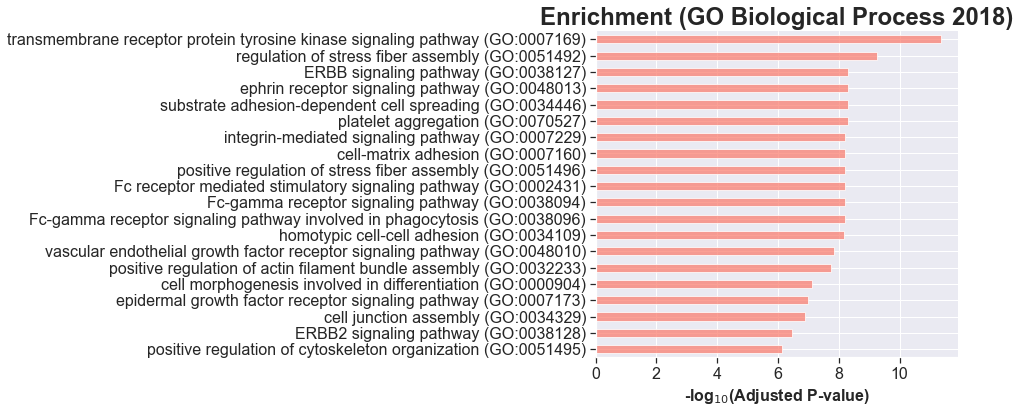

In [116]:
# GO analysis of these genes
enr = gseapy.enrichr(gene_list=genes_in_network.tolist(), gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='top_adhesome_hic', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))

# Barplot
plt.figure(figsize=(10,5))
barplot(enr.res2d, column='Adjusted P-value', title='Enrichment (GO Biological Process 2018)',
        cutoff=0.0001, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)
plt.show()

### Supplement: show HiC connections between chromosomes

In [4]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [5]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 64.27it/s]


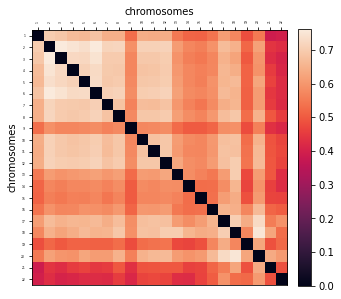

In [6]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())